# **SETUP & IMPORTS**

In [1]:
!pip install -q seaborn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score
)

from IPython.display import display

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True


# **LOAD DATASET**

In [2]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

df = X.copy()
df["target"] = y
df["target_name"] = pd.Categorical.from_codes(data.target, data.target_names)

print("Shape:", df.shape)
print("\nClass names (0/1):", data.target_names)
display(df.head())

Shape: (569, 32)

Class names (0/1): ['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,target_name
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,malignant


# **BASIC EDA**

This section provides an overview of the dataset before training any models. First, we display the class distribution (number of samples for each class) to check for imbalance. We then calculate the percentage distribution to understand how much each class contributes proportionally. Finally, we show summary statistics for all numerical features—such as mean, standard deviation, min/max values—styled with a color gradient to make patterns easier to spot. This helps verify data quality and gives an initial understanding of scale, spread, and potential preprocessing needs.

In [3]:
print("Class distribution:")
display(df["target_name"].value_counts().to_frame("count"))

# Percentage distribution
class_pct = df["target_name"].value_counts(normalize=True) * 100
print("\nClass percentage (%):")
display(class_pct.to_frame("percent"))

# Summary statistics
print("\nSummary statistics for features:")
display(df.describe().T.style.background_gradient(cmap="Blues"))


Class distribution:


,count
target_name,
benign,357
malignant,212



Class percentage (%):


,percent
target_name,
benign,62.741652
malignant,37.258348



Summary statistics for features:


,count,mean,std,min,25%,50%,75%,max
mean radius,569.000000,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.110000
mean texture,569.000000,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.280000
mean perimeter,569.000000,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.500000
mean area,569.000000,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.000000
mean smoothness,569.000000,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.163400
mean compactness,569.000000,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.345400
mean concavity,569.000000,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.426800
mean concave points,569.000000,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.201200
mean symmetry,569.000000,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.304000
mean fractal dimension,569.000000,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.097440


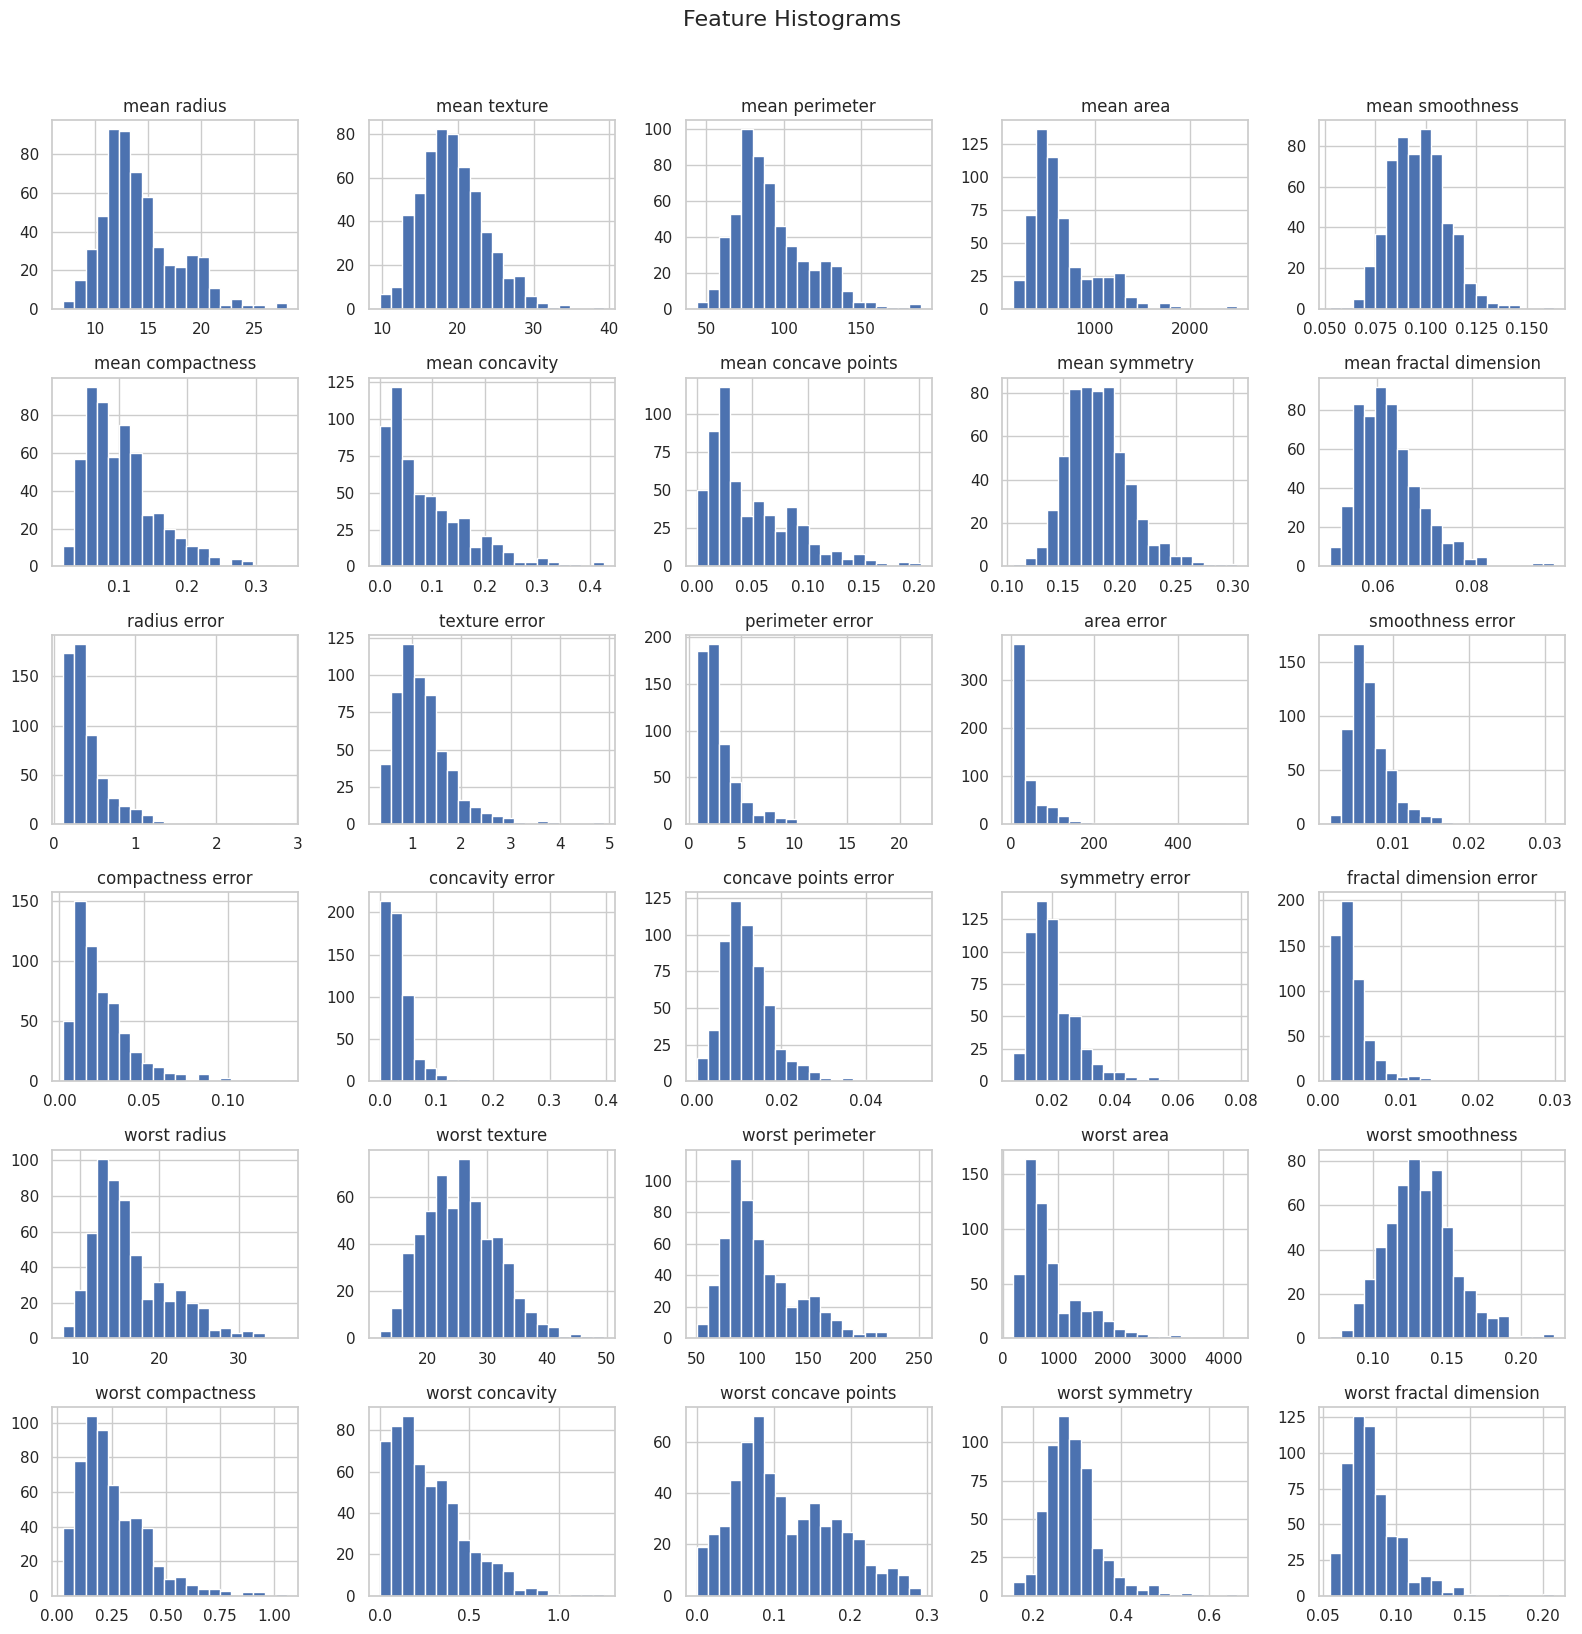

In [4]:
# Histograms of all features
df_features = df.drop(columns=["target", "target_name"])

df_features.hist(bins=20, figsize=(16, 16))
plt.suptitle("Feature Histograms", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


# **Correlation heatmap**

This block computes the correlation matrix and identifies the features most strongly correlated with the target variable. By sorting the correlations, we display the top 15 features that have the highest relationship (positive or negative) with the outcome. Then, we generate a heatmap of these top features to visualize how they relate both to the target and to one another. This helps reveal which features carry the most predictive signal and whether some variables are highly redundant due to strong inter-correlations.

Top 15 features correlated with target:


,corr_with_target
smoothness error,0.067016
mean fractal dimension,0.012838
texture error,0.008303
symmetry error,0.006522
fractal dimension error,-0.077972
concavity error,-0.253730
compactness error,-0.292999
worst fractal dimension,-0.323872
mean symmetry,-0.330499
mean smoothness,-0.358560


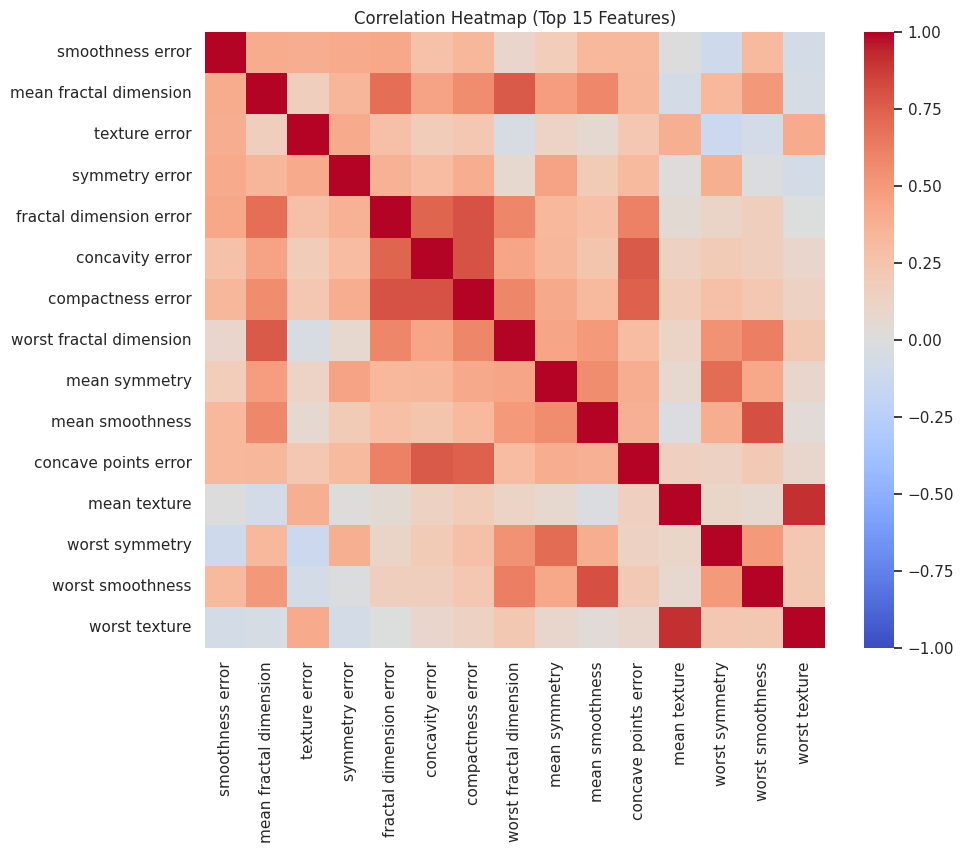

In [5]:
corr = df.corr(numeric_only=True)
target_corr = corr["target"].drop("target").sort_values(ascending=False)

print("Top 15 features correlated with target:")
display(target_corr.head(15).to_frame("corr_with_target"))

top_features = target_corr.head(15).index
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_features].corr(), annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Top 15 Features)")
plt.show()


# **TRAIN / TEST SPLIT**

In [6]:
X = df_features.values
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 455
Test size: 114


**classification_report_to_df:**

* Converts scikit-learn’s classification report into a clean, nicely formatted DataFrame. This allows easier styling, sorting, and display in Colab compared to plain text.

**plot_confusion_matrix:**

* Generates a heatmap-style confusion matrix using Seaborn. This visually shows how many samples were correctly or incorrectly predicted for each class, making model errors easy to interpret.

**plot_roc_curve:**

* Plots the ROC curve using predicted probabilities and computes the ROC AUC score. The curve shows the trade-off between true positive and false positive rates at different thresholds, helping evaluate how well the model separates the classes.

In [7]:
# Helper: classification report as a pretty DataFrame
def classification_report_to_df(y_true, y_pred, target_names=None):
    rpt_dict = classification_report(
        y_true, y_pred, target_names=target_names, output_dict=True
    )
    df_rpt = pd.DataFrame(rpt_dict).T
    return df_rpt

# Helper: plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Helper: plot ROC curve
def plot_roc_curve(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    return auc


# **BASELINE: LOGISTIC REGRESSION**




* Creates a Pipeline that scales the features (StandardScaler) and applies Logistic Regression.

* Fits the model on the training data and generates predictions + prediction probabilities.

* Computes accuracy and ROC AUC as key evaluation metrics.

* Displays a classification report as a styled table to summarize precision, recall, and F1-scores.

* Plots a confusion matrix to show correct vs incorrect predictions.

* Draws a ROC curve to visualize the model's ability to separate classes across thresholds.

=== Logistic Regression (Baseline) ===
Test Accuracy: 0.9825
Test ROC AUC : 0.9954



,precision,recall,f1-score,support
malignant,0.976190,0.976190,0.976190,42.000000
benign,0.986111,0.986111,0.986111,72.000000
accuracy,0.982456,0.982456,0.982456,0.982456
macro avg,0.981151,0.981151,0.981151,114.000000
weighted avg,0.982456,0.982456,0.982456,114.000000


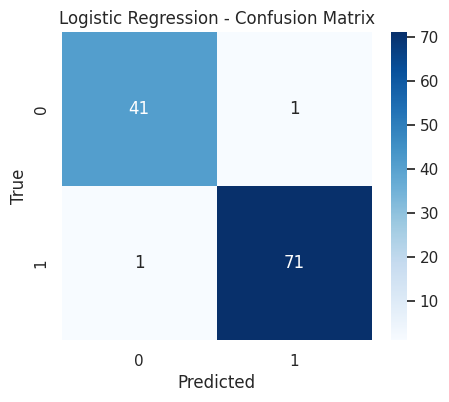

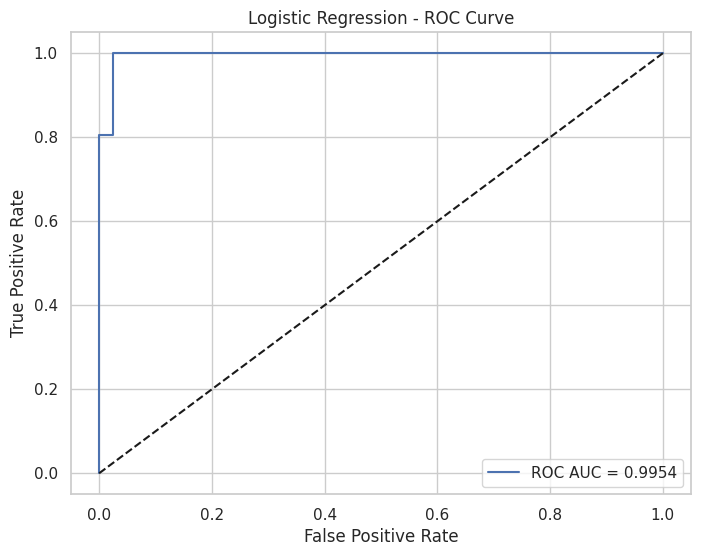

np.float64(0.9953703703703703)

In [8]:
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, random_state=42))
])

log_reg_pipeline.fit(X_train, y_train)

y_pred_lr = log_reg_pipeline.predict(X_test)
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print("=== Logistic Regression (Baseline) ===")
print(f"Test Accuracy: {acc_lr:.4f}")
print(f"Test ROC AUC : {auc_lr:.4f}\n")

# Classification report as table
report_lr = classification_report_to_df(
    y_test, y_pred_lr, target_names=data.target_names
)
display(report_lr.style.background_gradient(cmap="Purples"))

# Confusion matrix
plot_confusion_matrix(y_test, y_pred_lr, title="Logistic Regression - Confusion Matrix")

# ROC curve
plot_roc_curve(y_test, y_proba_lr, title="Logistic Regression - ROC Curve")


# **Logistic Regression (tuned)**

This section improves the baseline Logistic Regression model by performing hyperparameter tuning using GridSearchCV. We define a parameter grid for the regularization strength C, test multiple values using 5-fold stratified cross-validation, and select the model that achieves the highest ROC AUC during CV. After training, we evaluate the best model on the test set and record its accuracy and AUC. Finally, we visualize the tuned model’s performance using a confusion matrix and ROC curve, allowing us to compare how tuning affects the model compared to the default baseline.

Fitting 5 folds for each of 5 candidates, totalling 25 fits

=== Tuned Logistic Regression ===
Best params: {'clf__C': 1}
CV ROC AUC (mean): 0.9959
Test Accuracy    : 0.9825
Test ROC AUC     : 0.9954


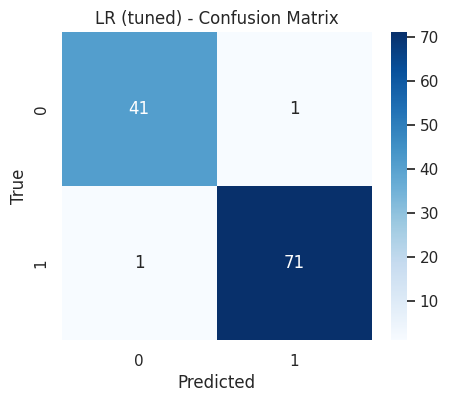

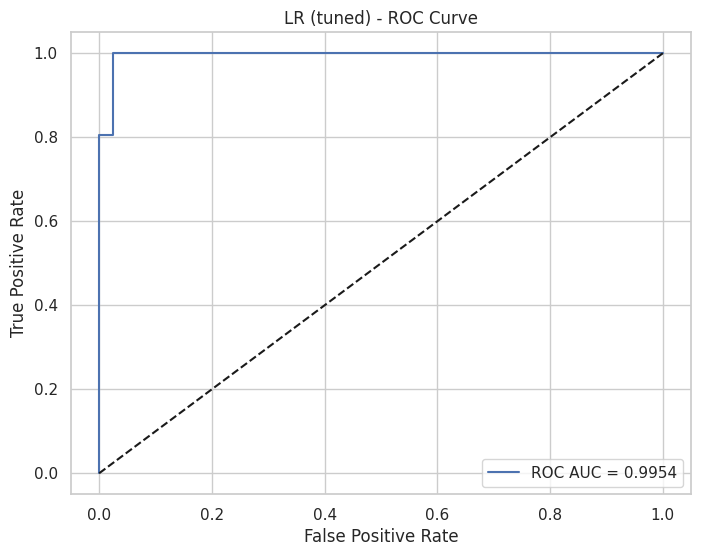

np.float64(0.9953703703703703)

In [9]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_summary = []

# 5.1 Logistic Regression (with C tuning)
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, random_state=42))
])

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10, 100]
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
y_pred_lr_gs = best_lr.predict(X_test)
y_proba_lr_gs = best_lr.predict_proba(X_test)[:, 1]

acc_lr_gs = accuracy_score(y_test, y_pred_lr_gs)
auc_lr_gs = roc_auc_score(y_test, y_proba_lr_gs)

results_summary.append({
    "Model": "LogisticRegression (tuned)",
    "Best Params": grid_lr.best_params_,
    "CV AUC (mean)": grid_lr.best_score_,
    "Test Accuracy": acc_lr_gs,
    "Test AUC": auc_lr_gs
})

print("\n=== Tuned Logistic Regression ===")
print("Best params:", grid_lr.best_params_)
print(f"CV ROC AUC (mean): {grid_lr.best_score_:.4f}")
print(f"Test Accuracy    : {acc_lr_gs:.4f}")
print(f"Test ROC AUC     : {auc_lr_gs:.4f}")

plot_confusion_matrix(y_test, y_pred_lr_gs, title="LR (tuned) - Confusion Matrix")
plot_roc_curve(y_test, y_proba_lr_gs, title="LR (tuned) - ROC Curve")


# **SVM (RBF kernel)**

In this block, we train a Support Vector Machine with an RBF kernel and optimize its key hyperparameters using GridSearchCV. We tune the regularization strength C and the kernel sensitivity gamma, evaluating each combination through 5-fold stratified cross-validation based on ROC AUC. After identifying the best parameter set, we test the optimized SVM on the hold-out test set and record its accuracy and AUC. Finally, a confusion matrix and ROC curve are plotted to visualize how well the tuned SVM separates the two classes compared to other models.

Fitting 5 folds for each of 9 candidates, totalling 45 fits

=== SVM (RBF) ===
Best params: {'clf__C': 10, 'clf__gamma': 0.01}
CV ROC AUC (mean): 0.9964
Test Accuracy    : 0.9825
Test ROC AUC     : 0.9977


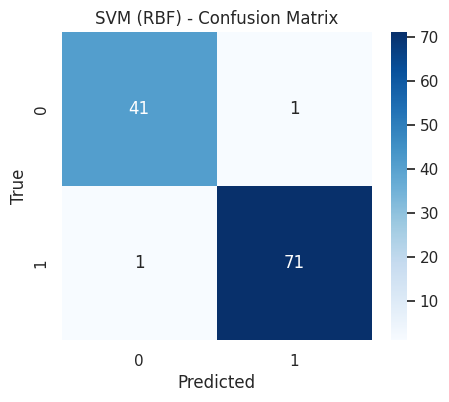

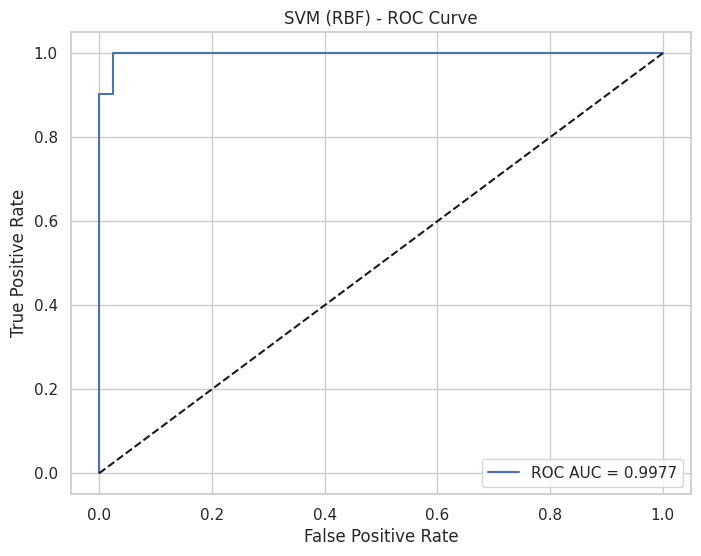

np.float64(0.9976851851851851)

In [10]:
# 5.2 SVM (RBF kernel)
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=42))
])

param_grid_svm = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.001]
}

grid_svm = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
y_proba_svm = best_svm.predict_proba(X_test)[:, 1]

acc_svm = accuracy_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_proba_svm)

results_summary.append({
    "Model": "SVM (RBF)",
    "Best Params": grid_svm.best_params_,
    "CV AUC (mean)": grid_svm.best_score_,
    "Test Accuracy": acc_svm,
    "Test AUC": auc_svm
})

print("\n=== SVM (RBF) ===")
print("Best params:", grid_svm.best_params_)
print(f"CV ROC AUC (mean): {grid_svm.best_score_:.4f}")
print(f"Test Accuracy    : {acc_svm:.4f}")
print(f"Test ROC AUC     : {auc_svm:.4f}")

plot_confusion_matrix(y_test, y_pred_svm, title="SVM (RBF) - Confusion Matrix")
plot_roc_curve(y_test, y_proba_svm, title="SVM (RBF) - ROC Curve")


# **Random Forest**

This section trains a Random Forest classifier and tunes its main hyperparameters using GridSearchCV. We search over different values for the number of trees (n_estimators), the maximum tree depth, and the minimum samples required to split a node. Each configuration is evaluated using 5-fold stratified cross-validation based on ROC AUC. After selecting the best-performing model, we test it on the held-out test set and compute its accuracy and AUC. The confusion matrix and ROC curve help visualize how well the tuned Random Forest distinguishes between the two classes and how its performance compares to the previous models.

Fitting 5 folds for each of 12 candidates, totalling 60 fits

=== Random Forest ===
Best params: {'clf__max_depth': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
CV ROC AUC (mean): 0.9908
Test Accuracy    : 0.9561
Test ROC AUC     : 0.9927


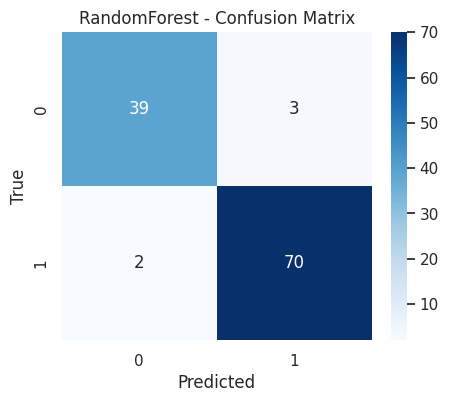

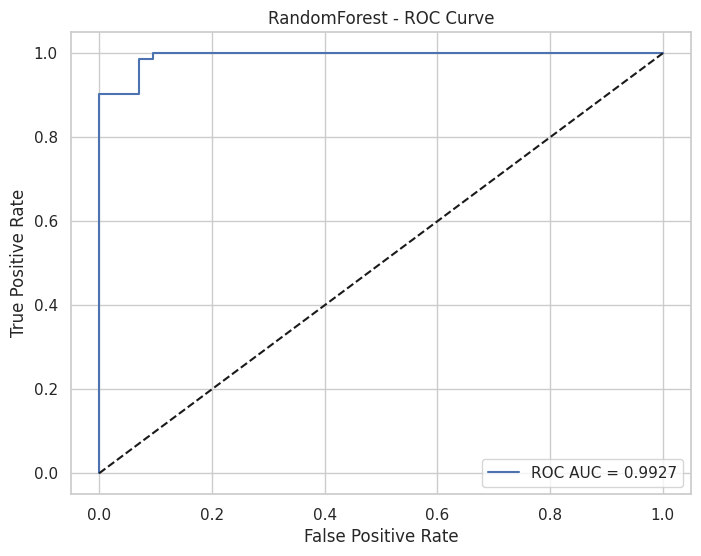

np.float64(0.9927248677248677)

In [11]:
# 5.3 Random Forest
pipe_rf = Pipeline([
    # scaler is not strictly needed for trees, but we keep same interface
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    "clf__n_estimators": [100, 300],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

results_summary.append({
    "Model": "RandomForest",
    "Best Params": grid_rf.best_params_,
    "CV AUC (mean)": grid_rf.best_score_,
    "Test Accuracy": acc_rf,
    "Test AUC": auc_rf
})

print("\n=== Random Forest ===")
print("Best params:", grid_rf.best_params_)
print(f"CV ROC AUC (mean): {grid_rf.best_score_:.4f}")
print(f"Test Accuracy    : {acc_rf:.4f}")
print(f"Test ROC AUC     : {auc_rf:.4f}")

plot_confusion_matrix(y_test, y_pred_rf, title="RandomForest - Confusion Matrix")
plot_roc_curve(y_test, y_proba_rf, title="RandomForest - ROC Curve")


# **Gradient Boosting**

This block trains a Gradient Boosting classifier and tunes its key hyperparameters using GridSearchCV. The search explores different combinations of the number of boosting stages, learning rate, and tree depth—each affecting how strongly and how quickly the model learns patterns from the data. Using 5-fold stratified cross-validation scored by ROC AUC, we select the best-performing configuration and then evaluate it on the test set. The resulting accuracy, AUC, confusion matrix, and ROC curve reveal how effectively the tuned Gradient Boosting model captures complex relationships and how it compares to the other classifiers.

Fitting 5 folds for each of 12 candidates, totalling 60 fits

=== Gradient Boosting ===
Best params: {'clf__learning_rate': 0.2, 'clf__max_depth': 1, 'clf__n_estimators': 200}
CV ROC AUC (mean): 0.9929
Test Accuracy    : 0.9561
Test ROC AUC     : 0.9934


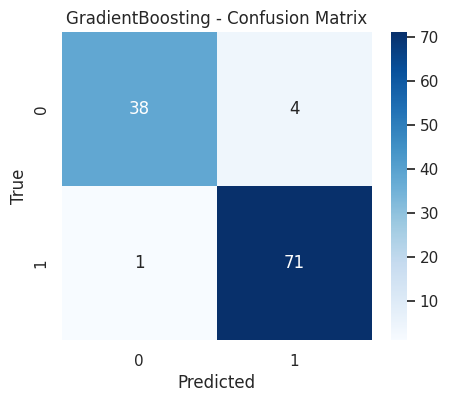

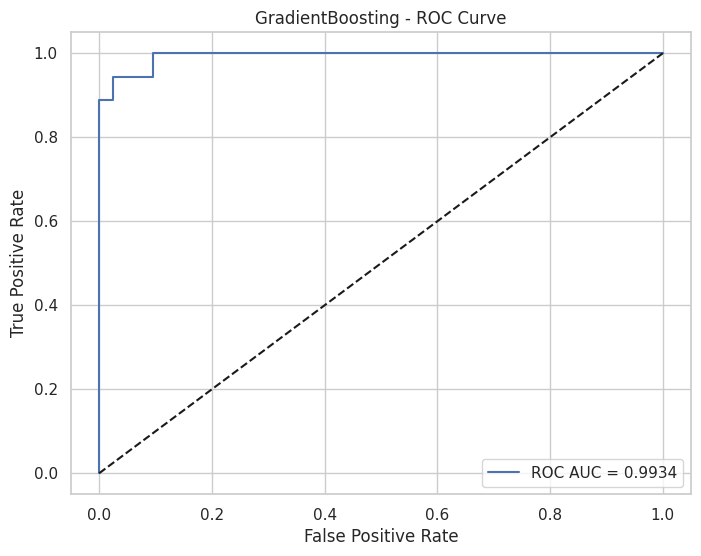

np.float64(0.9933862433862434)

In [12]:
# 5.4 Gradient Boosting
pipe_gb = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(random_state=42))
])

param_grid_gb = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1, 0.2],
    "clf__max_depth": [1, 3]
}

grid_gb = GridSearchCV(
    pipe_gb,
    param_grid_gb,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_gb.fit(X_train, y_train)

best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)
y_proba_gb = best_gb.predict_proba(X_test)[:, 1]

acc_gb = accuracy_score(y_test, y_pred_gb)
auc_gb = roc_auc_score(y_test, y_proba_gb)

results_summary.append({
    "Model": "GradientBoosting",
    "Best Params": grid_gb.best_params_,
    "CV AUC (mean)": grid_gb.best_score_,
    "Test Accuracy": acc_gb,
    "Test AUC": auc_gb
})

print("\n=== Gradient Boosting ===")
print("Best params:", grid_gb.best_params_)
print(f"CV ROC AUC (mean): {grid_gb.best_score_:.4f}")
print(f"Test Accuracy    : {acc_gb:.4f}")
print(f"Test ROC AUC     : {auc_gb:.4f}")

plot_confusion_matrix(y_test, y_pred_gb, title="GradientBoosting - Confusion Matrix")
plot_roc_curve(y_test, y_proba_gb, title="GradientBoosting - ROC Curve")


# **SUMMARY TABLE OF ALL MODELS**

This final block compiles all model results into a single DataFrame to make comparison easier. After converting the metrics to numeric types, we display a styled table showing each model’s cross-validation AUC, test accuracy, test AUC, and best hyperparameters. The table is sorted by test AUC so the best-performing model appears at the top. Color-shaded gradients help visually highlight stronger and weaker scores across metrics, making it easy to compare how each tuned model performed relative to the others.

In [13]:
results_df = pd.DataFrame(results_summary)
results_df["CV AUC (mean)"] = results_df["CV AUC (mean)"].astype(float)
results_df["Test Accuracy"] = results_df["Test Accuracy"].astype(float)
results_df["Test AUC"] = results_df["Test AUC"].astype(float)

display(
    results_df[
        ["Model", "CV AUC (mean)", "Test Accuracy", "Test AUC", "Best Params"]
    ].sort_values(by="Test AUC", ascending=False)
     .style.background_gradient(cmap="YlGnBu", subset=["CV AUC (mean)", "Test Accuracy", "Test AUC"])
     .format({"CV AUC (mean)": "{:.4f}", "Test Accuracy": "{:.4f}", "Test AUC": "{:.4f}"})
)


,Model,CV AUC (mean),Test Accuracy,Test AUC,Best Params
1,SVM (RBF),0.9964,0.9825,0.9977,"{'clf__C': 10, 'clf__gamma': 0.01}"
0,LogisticRegression (tuned),0.9959,0.9825,0.9954,{'clf__C': 1}
3,GradientBoosting,0.9929,0.9561,0.9934,"{'clf__learning_rate': 0.2, 'clf__max_depth': 1, 'clf__n_estimators': 200}"
2,RandomForest,0.9908,0.9561,0.9927,"{'clf__max_depth': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}"
